In [169]:
import pandas as pd
import torch
import os 
from matplotlib import pyplot as plt
import matplotlib
import json
from Utilities import load_model
import logging

from ConvNetwork import ConvNet
from Tester import TestTools

import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim


In [2]:
import numpy as np

In [3]:
def init_logging(log_file=None, append=False, console_loglevel=logging.INFO):
    """https://www.programcreek.com/python/example/136/logging.basicConfig"""
    """Set up logging to file and console."""
    if log_file is not None:
        if append:
            filemode_val = 'a'
        else:
            filemode_val = 'w'
        logging.basicConfig(level=logging.DEBUG,
                            format="%(asctime)s %(levelname)s %(threadName)s %(name)s %(message)s",
                            # datefmt='%m-%d %H:%M',
                            filename=log_file,
                            filemode=filemode_val)
    # define a Handler which writes INFO messages or higher to the sys.stderr
    console = logging.StreamHandler()
    console.setLevel(console_loglevel)
    # set a format which is simpler for console use
    formatter = logging.Formatter("%(message)s")
    console.setFormatter(formatter)
    # add the handler to the root logger
    logging.getLogger('').addHandler(console)
    global LOG
    LOG = logging.getLogger(__name__) 

In [4]:
init_logging()

# Load Pretrained Model

In [5]:
with open("./Config/output.json","r") as fin:
     output_conf=json.load(fin)

In [6]:
model=load_model(output_conf["path"]["model"],ConvNet,{"in_feature_2d":(28,28),"out_feature":10})

In [7]:
model.eval()

ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (act1): ReLU()
  (pooling1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (act2): ReLU()
  (pooling2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (act3): ReLU()
  (pooling3): MaxPool2d(kernel_size=(7, 7), stride=(7, 7), padding=0, dilation=1, ceil_mode=False)
  (featureFC): Linear(in_features=32, out_features=2, bias=True)
  (outputFC): Linear(in_features=2, out_features=10, bias=True)
)

## Get data set

In [8]:
DEBUG=False
batch_size=None if DEBUG else 64
shuffle_flag=False if DEBUG else True
random_seed=1
if DEBUG:
    torch.manual_seed(random_seed)

train_data=torchvision.datasets.MNIST("./data",train=True,download=True,transform=torchvision.transforms.ToTensor())
test_data=torchvision.datasets.MNIST("./data",train=False,download=True,transform=torchvision.transforms.ToTensor())# Warning: ToTensor will divide the original data by 255
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=shuffle_flag,) 
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=shuffle_flag)

In [9]:
TestTools.accuracy_rate(model,train_data.data/255,train_data.targets)

0.9665166666666667

In [10]:

TestTools.accuracy_rate(model,test_data.data/255,test_data.targets)

0.9574

## Extract feature vectors

In [11]:
feature_gallery_path="./result/feature_gallery.csv"
if not os.path.exists(feature_gallery_path):
    feature_gallery=model.feature_extraction(train_data.data.reshape(-1,1,28,28)/255).detach().numpy()
    feature_gallery_df=pd.concat([pd.DataFrame(feature_gallery,columns=["x","y"]),pd.DataFrame(train_data.targets.numpy(),columns=["label"])],axis=1,join="inner")
    if DEBUG: print(feature_gallery_df.head())
    # persistance the feature gallery for further process
    feature_gallery_df.to_csv(feature_gallery_path,index=False)
else:
    feature_gallery_df=pd.read_csv(feature_gallery_path)

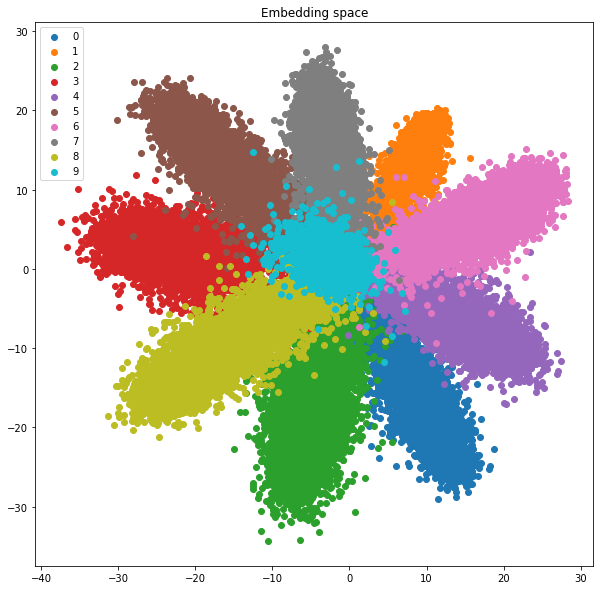

In [12]:
fig=plt.figure("Gallery Embedding space",figsize=(10,10))
ax=fig.subplots(1,1)
for key,data in feature_gallery_df.groupby("label"):
    ax.scatter(data["x"],data["y"],label=key)
ax.set_title("Embedding space")
ax.legend()

In [193]:
class VisualizationEmbeding():
    def __init__(self,dataset,random_seed=0) -> None:
        self.dataset=dataset
        np.random.seed(random_seed)

    def sample_datas(self,sample_nums):
        self.samples=self._get_n_samples(sample_nums)
    
    def _get_n_samples(self,n):
        samples={}
        for num in range(10):
            digit_set=torch.where(train_data.targets==num)[0]
            random_idx=np.random.randint(0,len(digit_set)+1,n)
            samples[num]=digit_set[random_idx]
        return samples
    
    def draw_embeding_space(self,all_points):
        # Plot and show
        colors = matplotlib.cm.Paired(np.linspace(0, 1, len(all_points)))
        fig=plt.figure(figsize=(10,10))
        ax = fig.subplots ()
        for (points,color,digit)in zip(all_points,colors,range (10)):
            ax.scatter ([item [0] for item in points],[item [1] for item in points],color=color , label="digit {}".format(digit))
            ax.grid(True)
            ax.legend ()
        fig.show()
    
    def feature_exract_draw(self,model):
        all_points=[]
        for i in range(10):
            index=self.samples[i]
            data=self.dataset.data[index].reshape(-1,1,28,28)/255
            targets=self.dataset.targets[index]
            all_points.append(model.feature_extraction(data).detach().numpy())
        self.draw_embeding_space(all_points)

    def __call__(self,model):
        self.feature_exract_draw(model)
        

In [194]:
embeding_space_vis=VisualizationEmbeding(train_data,0)

C:\Users\20211575\AppData\Local\Temp/ipykernel_11864/2934014858.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


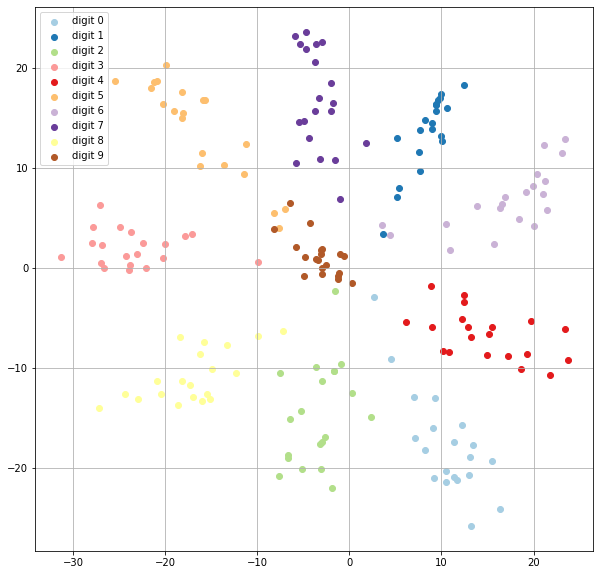

In [195]:
embeding_space_vis.sample_datas(20)
embeding_space_vis(model)

In [166]:
samples=None
samples=get_n_samples(20,0)

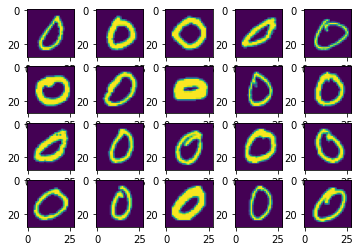

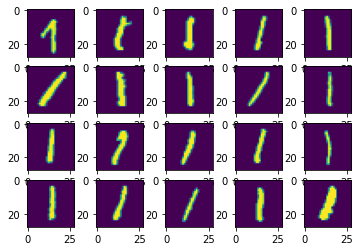

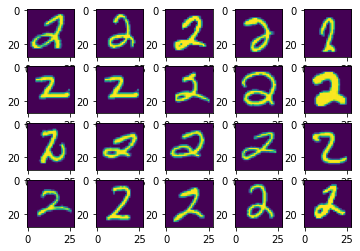

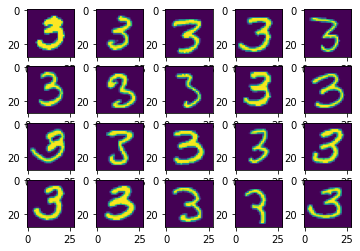

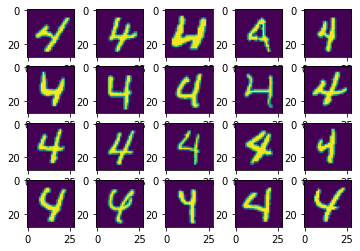

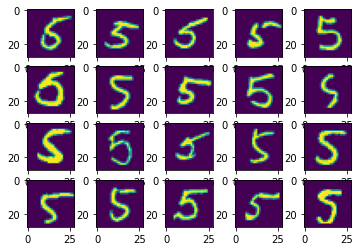

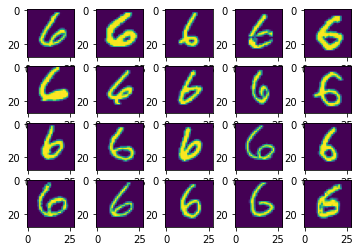

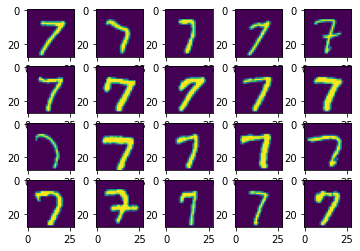

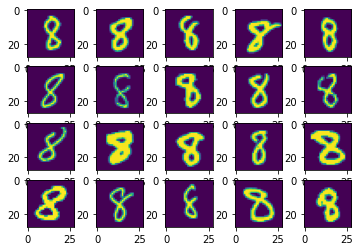

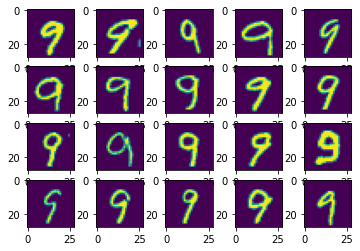

In [167]:
for key,data in samples.items():
    fig=plt.figure()
    ax=np.array(fig.subplots(4,5)).ravel()
    for i in range(len(data)):
        ax[i].imshow(train_data.data[data[i]])

In [127]:
class QueryReID():
    def __init__(self,model,gallery_data,gallery_targets,dist_func="euclidean",gallery=None) -> None:
        self.model=model
        self.model.eval()
        self.gallery_data=gallery_data
        self.gallery_targets=gallery_targets
        if gallery is None:
            self.init_gallery()
        else:
            self.gallery=gallery 
        if dist_func.upper()=="EUCLIDEAN".upper():
            self.distance=self.euclidien_square_distance

    def init_gallery(self):
        feature_gallery=self.model.feature_extraction(self.gallery_data.reshape(-1,1,28,28)).detach().numpy()
        self.gallery=pd.concat([pd.DataFrame(feature_gallery,columns=["x","y"]),pd.DataFrame(self.gallery_targets,columns=["label"])],axis=1,join="inner")
    
    def inner_distance(self,vector1,vector2):
        assert (vector1.shape[1]==vector2.shape[1]), str(vector1.shape)+"not comply"+str(vector2.shape)
        return (vector1@vector2.T).squeeze()
    
    def euclidien_square_distance(self,vector1,vector2):
        """
        Return Distance between every row vector in vector 1 and every row vector in vector2
        i.e. reuslt[i][j]=dist(vector1[i,:],vector2[j,:])
        """
        assert (vector1.shape[1]==vector2.shape[1]), str(vector1.shape)+"not comply"+str(vector2.shape)
        return np.linalg.norm((feature_temp-mnist_query.gallery[["x","y"]].to_numpy()[:,None]),axis=-1).T

    def query(self,data,k):
        """
        batch query
        """
        feature=self.get_query_feature(data)
        score =np.linalg.norm((feature-self.gallery[["x","y"]].to_numpy()[:,None]),axis=-1).T
        return np.argsort(score,axis=1)[:,:k]

    def get_query_feature(self,data):
        return self.model.feature_extraction(data).detach().numpy().reshape(-1,2)

    def get_gallery_feature(self,idx):
        return self.gallery[idx]

    def get_gallery_data(self,idx):
        return (self.gallery_data[idx],self.gallery_targets[idx])


In [128]:
mnist_query=QueryReID(model,train_data.data.float().numpy()/255,train_data.targets.numpy(),gallery=feature_gallery_df)

In [129]:
mnist_query.get_query_feature(test_data.data[0].reshape(-1,1,28,28).float()/255)

array([[-4.766884, 20.874949]], dtype=float32)

digit7 	 sample idx 0 	 TOP 20 accuracy 1.0
digit2 	 sample idx 1 	 TOP 20 accuracy 0.9
digit1 	 sample idx 2 	 TOP 20 accuracy 1.0
digit0 	 sample idx 3 	 TOP 20 accuracy 1.0
digit4 	 sample idx 4 	 TOP 20 accuracy 1.0
digit1 	 sample idx 5 	 TOP 20 accuracy 1.0
digit4 	 sample idx 6 	 TOP 20 accuracy 1.0
digit6 	 sample idx 156 	 TOP 20 accuracy 1.0
digit7 	 sample idx 8749 	 TOP 20 accuracy 1.0
digit1 	 sample idx 9845 	 TOP 20 accuracy 1.0


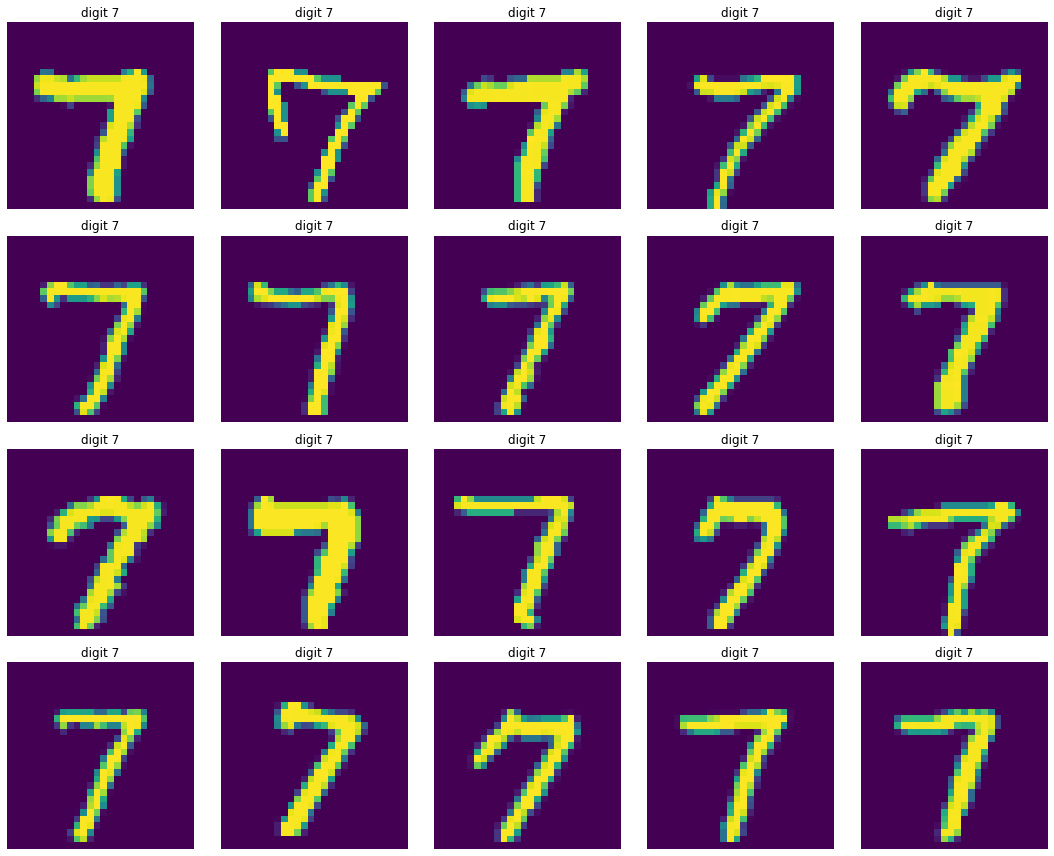

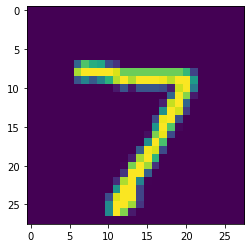

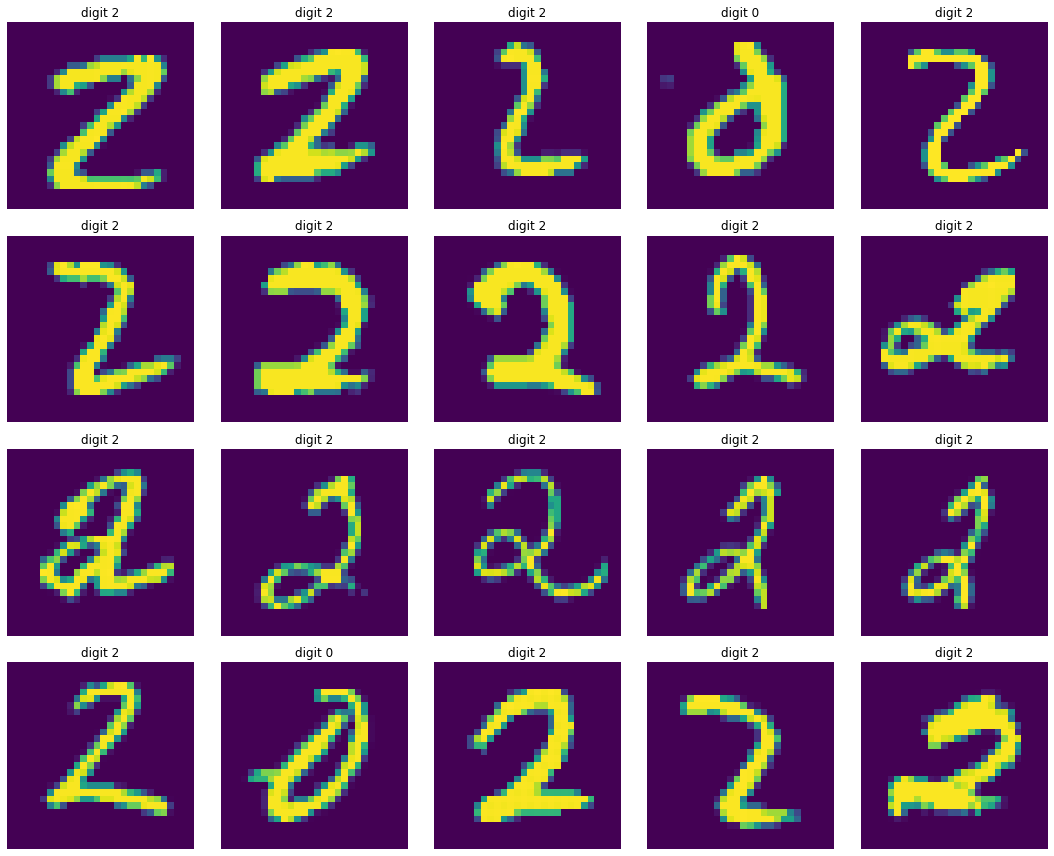

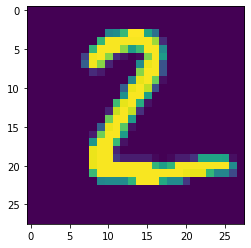

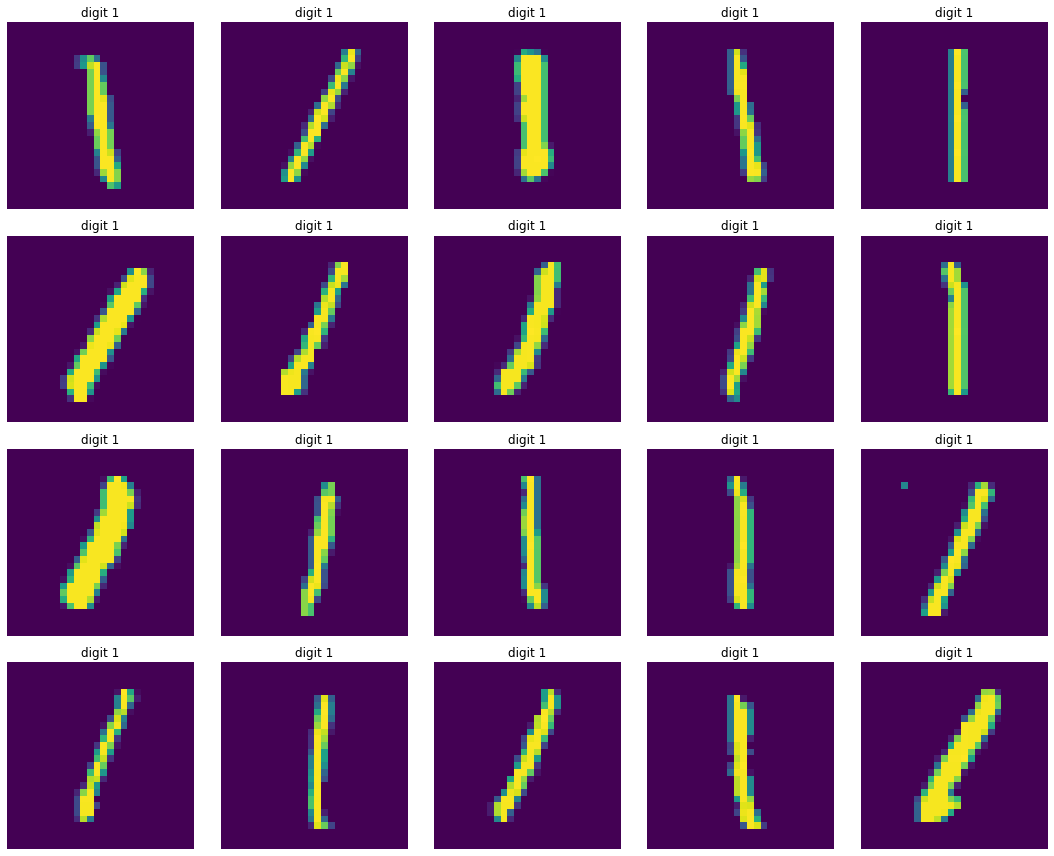

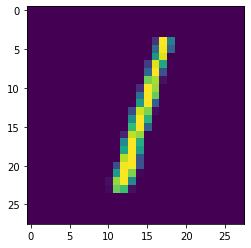

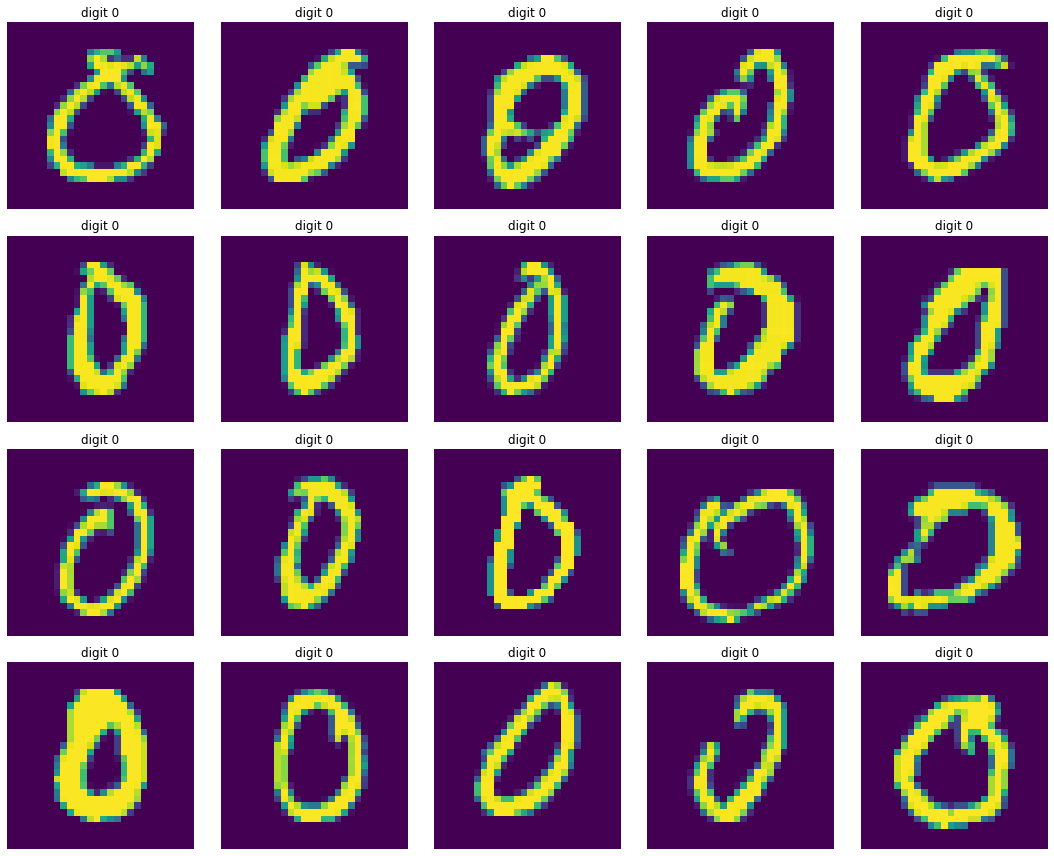

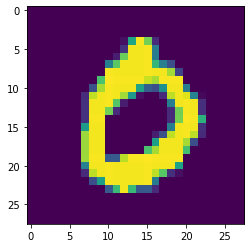

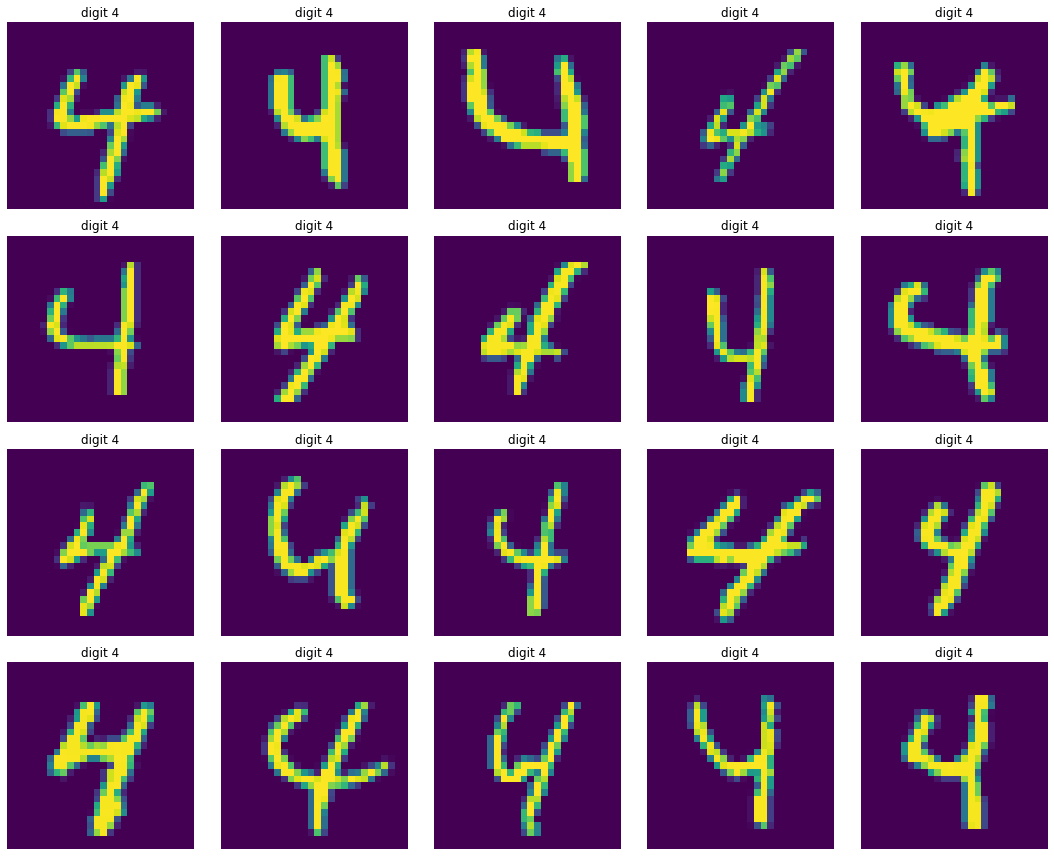

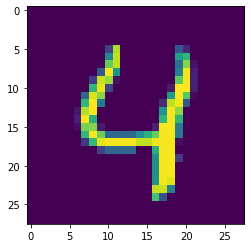

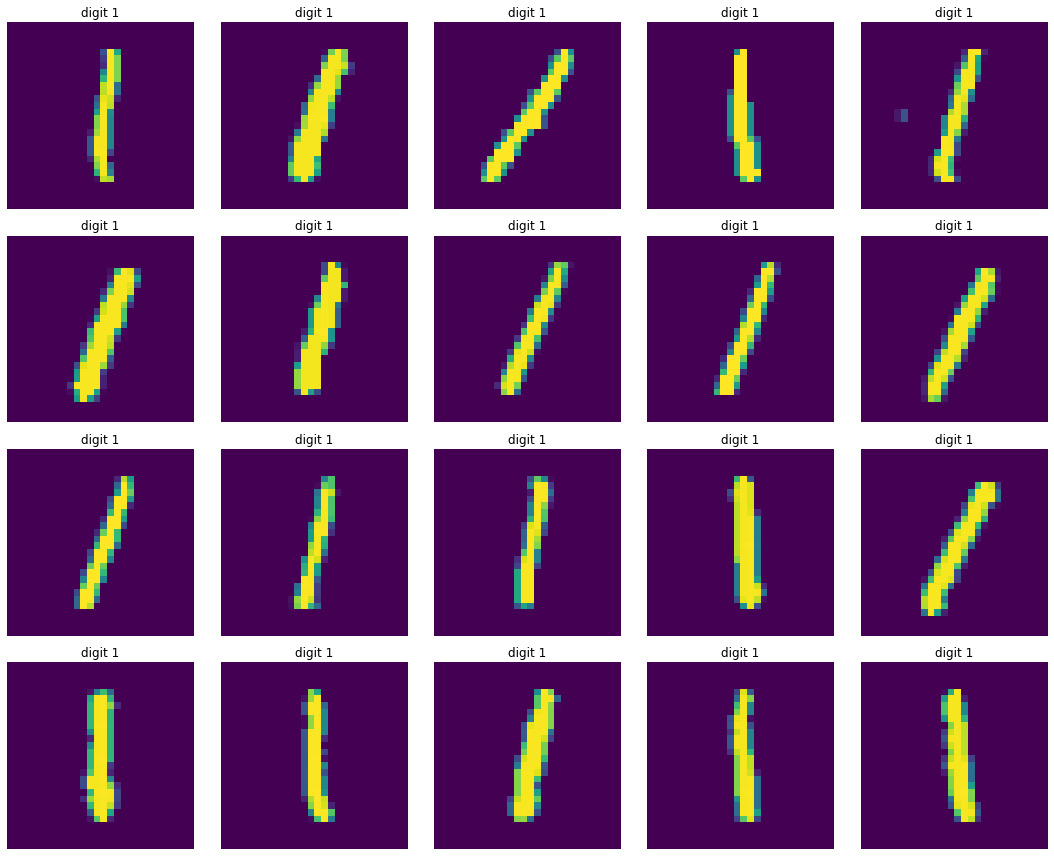

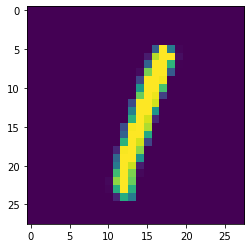

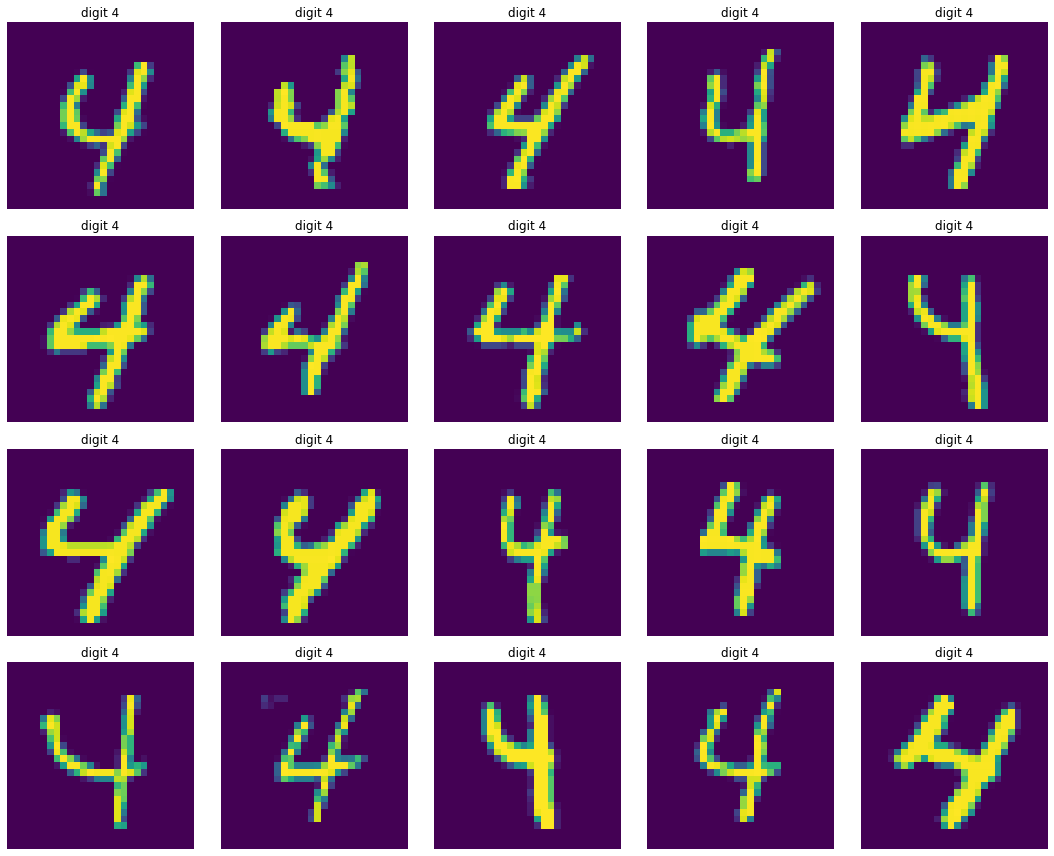

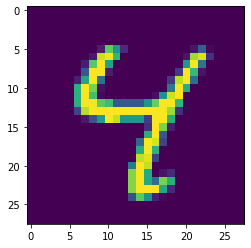

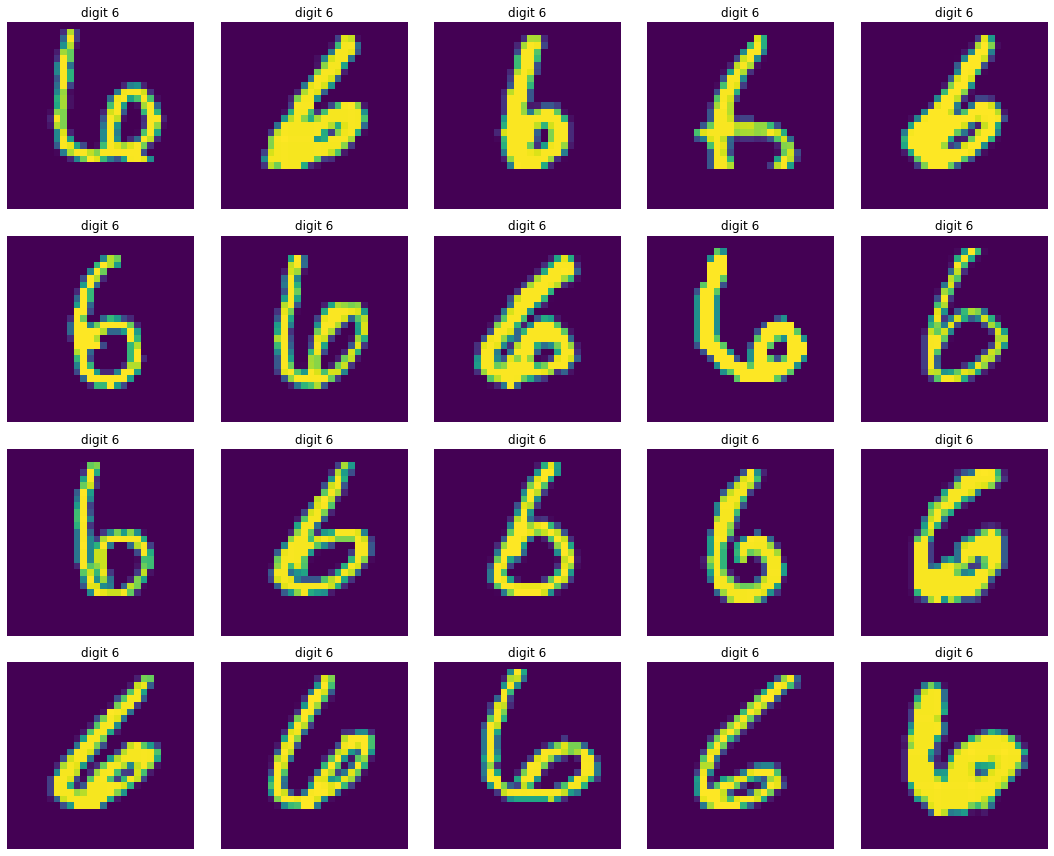

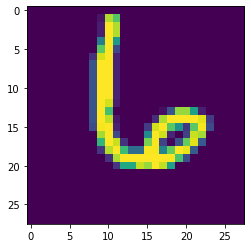

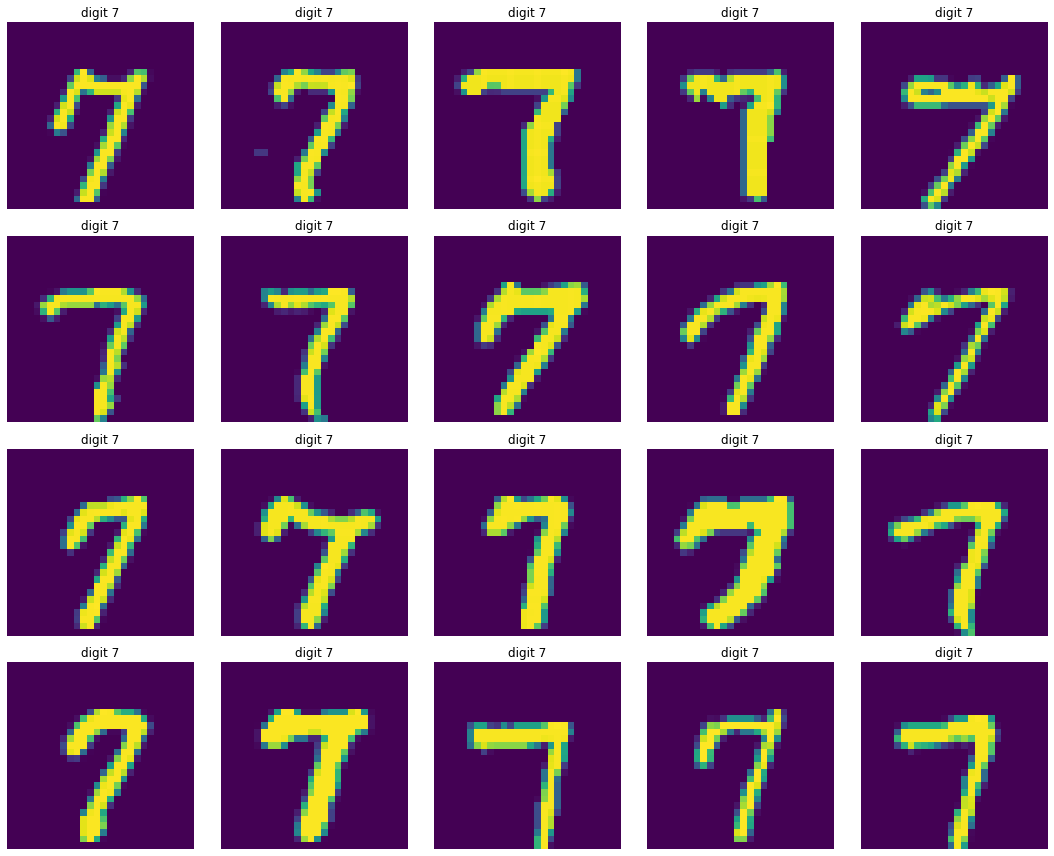

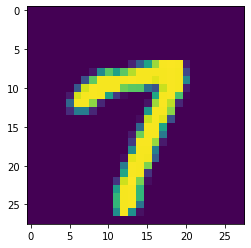

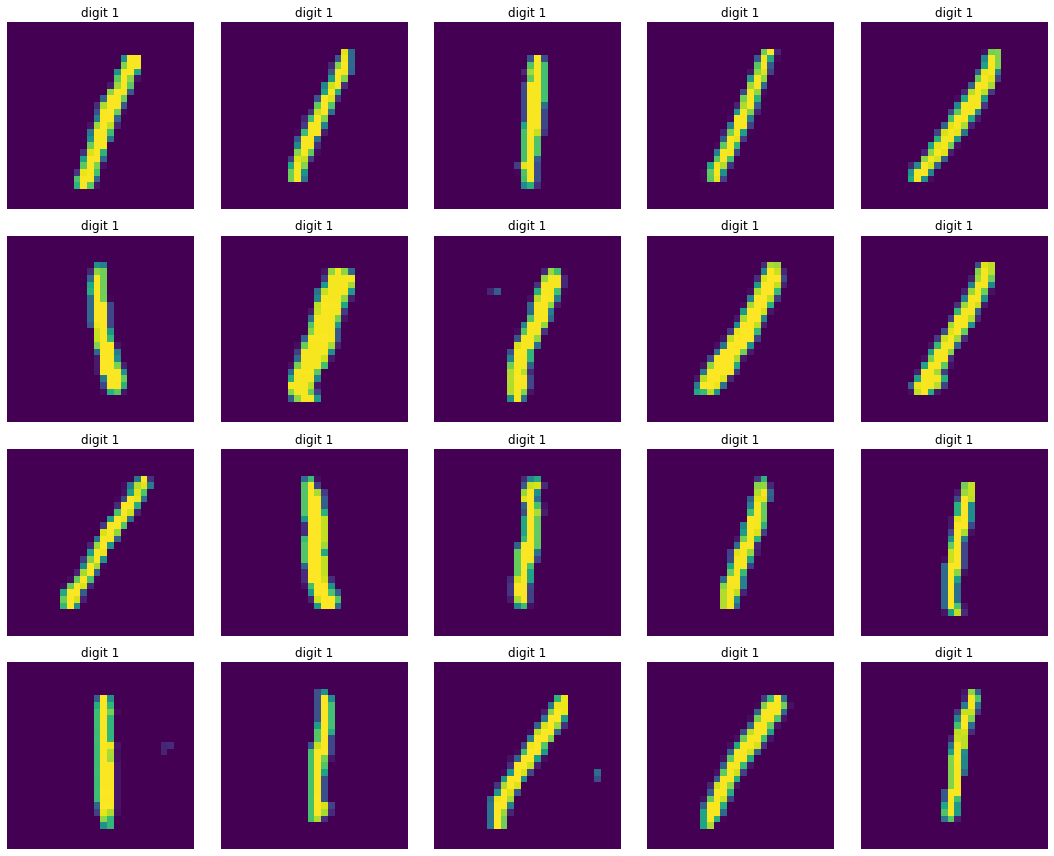

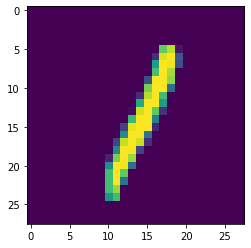

In [138]:
idx=[0,1,2,3,4,5,6,156,8749,9845]
query_data=test_data.data[idx].reshape(-1,1,28,28).float()/255
query_target=test_data.targets[idx].numpy()
quer_feature=mnist_query.get_query_feature(query_data)
top20=mnist_query.query(query_data,20)
for i in range(top20.shape[0]):
    data,targets=mnist_query.get_gallery_data(top20[i,:])
    print("digit{} \t sample idx {} \t TOP 20 accuracy {}".format(query_target[i],idx[i],np.sum(targets==query_target[i])/len(targets)))
    rows=4
    cols=5
    factor=3
    fig=plt.figure(figsize=(cols*factor,rows*factor))
    axes=np.array(fig.subplots(rows,cols)).ravel()
    for j in range(len(data)):
        axes[j].imshow(data[j])
        axes[j].set_title("digit {}".format(targets[j]))
        axes[j].axis("off")
    fig.tight_layout()
    fig2=plt.figure("query image{}".format(i))
    ax=fig2.subplots(1,1)
    ax.imshow(query_data[i].squeeze())

In [132]:
query_data.shape

torch.Size([2, 1, 28, 28])

In [57]:
feature_temp=model.feature_extraction(train_data.data[:10].float().reshape(-1,1,28,28)/255).detach().numpy()

In [90]:
np.linalg.norm((feature_temp[i]-mnist_query.gallery[["x","y"]].to_numpy()),axis=1).shape

(60000,)

In [86]:
for i in range(10):
    print(np.allclose((np.linalg.norm((feature_temp-mnist_query.gallery[["x","y"]].to_numpy()[:,None]),axis=-1).T)[i],np.linalg.norm((feature_temp[i]-mnist_query.gallery[["x","y"]].to_numpy()),axis=1)))

True
True
True
True
True
True
True
True
True
True


In [103]:
k=1
np.argsort(np.linalg.norm((feature_temp-mnist_query.gallery[["x","y"]].to_numpy()[:,None]),axis=-1).T,axis=1)[:,:k]

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]], dtype=int64)

In [78]:
print(feature_temp.shape)
print(mnist_query.gallery[["x","y"]].to_numpy()[:,None].shape)

(10, 2)
(60000, 1, 2)


In [68]:
feature_temp.shape

(10, 2)

In [73]:
(feature_temp-mnist_query.gallery[["x","y"]].to_numpy()[:5,None])[3][5]

array([-16.29713397, -36.28662901])

In [72]:
feature_temp[5]-mnist_query.gallery[["x","y"]].to_numpy()[3]

array([-16.29713397, -36.28662901])

In [58]:
for i in range(10):
    print(np.allclose((feature_temp[i,:]@mnist_query.gallery[["x","y"]].to_numpy().T),(feature_temp@mnist_query.gallery[["x","y"]].to_numpy().T)[i]))

True
True
True
True
True
True
True
True
True
True


In [41]:
np.argsort(feature_temp@mnist_query.gallery[["x","y"]].to_numpy().T)

array([[15525, 47937, 58225, ..., 18897, 47838, 25106],
       [18897, 29637, 48774, ..., 58489,  7728, 29395],
       [25106, 50935, 54780, ..., 15525, 47937, 58225]], dtype=int64)

In [ ]:
feature_temp@mnist_query.gallery[["x","y"]].to_numpy()[15525]

-664.8450634721376